## Import Libreries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

tf.test.is_gpu_available()

/home/david/.local/bin/.virtualenvs/david/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


True

## Show a fragment of the text

In [3]:
!head Adam_Smith_An_Inquiry_into_the_Nature_and_Causes_of_the_Wealth_of_Nations.txt

The greatest improvements in the productive powers of labour, and the greater part of the skill, dexterity, and judgment, with which it is anywhere directed, or applied, seem to have been the effects of the division of labour. The effects of the division of labour, in the general business of society, will be more easily understood, by considering in what manner it operates in some particular manufactures. It is commonly supposed to be carried furthest in some very trifling ones; not perhaps that it really is carried further in them than in others of more importance: but in those trifling manufactures which are destined to supply the small wants of but a small number of people, the whole number of workmen must necessarily be small; and those employed in every different branch of the work can often be collected into the same workhouse, and placed at once under the view of the spectator.

In those great manufactures, on the contrary, which are destined to supply the great wants of the gre

## Create Tokenizer

In [4]:
tokenizer = Tokenizer()

## Load Data

In [5]:
data = open('Adam_Smith_An_Inquiry_into_the_Nature_and_Causes_of_the_Wealth_of_Nations.txt').read()

## Create Corpus

In [6]:
corpus = data.lower().split("\n")
corpus = [line for line in corpus if line != '']

## Train Tokenizer

In [7]:
tokenizer.fit_on_texts(corpus)

In [8]:
total_words = len(tokenizer.word_index) +1

## Create input data

In [9]:
input_data = []

for line in corpus:
    token_sent = tokenizer.texts_to_sequences([line])[0]
    #print(token_sent)
    for i in range(1,len(token_sent)):
        my_gram_seq = token_sent[:i+1]
        #print(my_gram_seq)
        input_data.append(my_gram_seq)

## Create Pad Sequences & labels

In [10]:
max_sequence_len = max([len(x) for x in input_data])
input_data = np.array(pad_sequences(input_data, maxlen=max_sequence_len, padding='pre'))

In [11]:
print(input_data)

[[  0   0   0 ...   0   1 248]
 [  0   0   0 ...   1 248 143]
 [  0   0   0 ... 248 143   3]
 ...
 [  0   0   0 ...   2 203  74]
 [  0   0   0 ... 203  74 809]
 [  0   0   0 ...  74 809 810]]


In [12]:
X , y = input_data[:,:-1], input_data[:,-1]

In [13]:
y_cat = tf.keras.utils.to_categorical(y, num_classes=total_words)

## Build the model

In [14]:
model = tf.keras.models.Sequential()

In [15]:
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

In [16]:
model.add(Bidirectional(LSTM(150)))

In [17]:
model.add(Dense(total_words, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 763, 100)          81100     
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 811)               244111    
Total params: 626,411
Trainable params: 626,411
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [20]:
history = model.fit(X, y_cat, epochs=25, verbose=1)

Train on 3484 samples
Epoch 1/25
3484/3484 [==============================] - 11s 3ms/sample - loss: 5.8934 - accuracy: 0.0795
Epoch 2/25
3484/3484 [==============================] - 9s 2ms/sample - loss: 5.5284 - accuracy: 0.0878
Epoch 3/25
3484/3484 [==============================] - 8s 2ms/sample - loss: 5.3741 - accuracy: 0.1042
Epoch 4/25
3484/3484 [==============================] - 9s 2ms/sample - loss: 5.0992 - accuracy: 0.1300
Epoch 5/25
3484/3484 [==============================] - 8s 2ms/sample - loss: 4.7562 - accuracy: 0.1564
Epoch 6/25
3484/3484 [==============================] - 8s 2ms/sample - loss: 4.4017 - accuracy: 0.1857
Epoch 7/25
3484/3484 [==============================] - 8s 2ms/sample - loss: 4.0564 - accuracy: 0.2118
Epoch 8/25
3484/3484 [==============================] - 8s 2ms/sample - loss: 3.7184 - accuracy: 0.2402
Epoch 9/25
3484/3484 [==============================] - 8s 2ms/sample - loss: 3.4129 - accuracy: 0.2807
Epoch 10/25
3484/3484 [==================

## Plot Train Accuracy

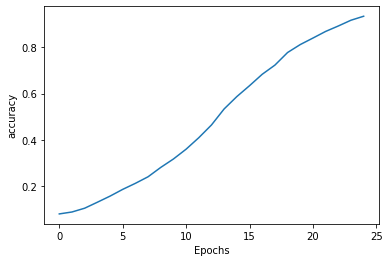

In [21]:
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

## Predict next 5 words

In [22]:
my_text = "from the growers of the flax and the wool, to the bleachers and"
next_words = 5
  
for _ in range(next_words):
    token_sent = tokenizer.texts_to_sequences([my_text])[0]
    token_sent = pad_sequences([token_sent], maxlen=max_sequence_len-1, padding='pre')
    prediction = model.predict_classes(token_sent, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == prediction:
            output_word = word
            break
    my_text += " " + output_word
print(my_text)

from the growers of the flax and the wool, to the bleachers and common smith which the quantity


## Predict next 10 words

In [23]:
my_text = "from the growers of the flax and the wool, to the bleachers and"
next_words = 10
  
for _ in range(next_words):
    token_sent = tokenizer.texts_to_sequences([my_text])[0]
    token_sent = pad_sequences([token_sent], maxlen=max_sequence_len-1, padding='pre')
    prediction = model.predict_classes(token_sent, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == prediction:
            output_word = word
            break
    my_text += " " + output_word
print(my_text)

from the growers of the flax and the wool, to the bleachers and common smith which the quantity of the people of the


## Predict next 15 words

In [26]:
my_text = "from the growers of the flax and the wool, to the bleachers and"
next_words = 15
  
for _ in range(next_words):
    token_sent = tokenizer.texts_to_sequences([my_text])[0]
    token_sent = pad_sequences([token_sent], maxlen=max_sequence_len-1, padding='pre')
    prediction = model.predict_classes(token_sent, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == prediction:
            output_word = word
            break
    my_text += " " + output_word
print(my_text)

from the growers of the flax and the wool, to the bleachers and common smith which the quantity of the people of the corn of labour is so
